In [2]:
import warnings
warnings.filterwarnings("ignore")
#from utils import *
import pickle


def get_studies(a_study):
    

    with open(f'{a_study}.pickle', 'rb') as handle:
        studies = pickle.load(handle)

    return studies    

import optuna
from optuna.trial import TrialState

def filter_studies(studies):
    new_studies = []
    for study in studies:
        # Get all completed trials in the study
        completed_trials = study.get_trials(states=[TrialState.COMPLETE])
        # Create a new study with the same study name but meant for multi-objective optimization
        new_study = optuna.create_study(study_name=study.study_name, directions=["maximize", "maximize"])
        # Create and add each trial to the new study
        for trial in completed_trials:
            new_trial = optuna.create_trial(
                params=trial.params,
                distributions=trial.distributions,
                values=trial.values,  # Use values instead of value for multi-objective optimization
                state=TrialState.COMPLETE,
            )
            new_study.add_trial(new_trial)
        new_studies.append(new_study)
    
    # Asserting that all trials in the new study are completed
    for study in new_studies:
        for trial in study.get_trials():
            assert trial.state == TrialState.COMPLETE

    return new_studies




chile = filter_studies(get_studies('results-5k/chile_cohort_5k'))
rome  = filter_studies(get_studies('results-5k/rome_cohort_5k'))
flor  = filter_studies(get_studies('results-5k/flor_cohort_5k'))
italy  = filter_studies(get_studies('results-5k/italy_cohort_5k'))
# chile = filter_studies(get_studies("results/studies_1k_chile_non_ntbc"))
# rome  = filter_studies(get_studies("results/studies_1k_rome_non_ntbc"))
# flor  = filter_studies(get_studies("results/studies_1k_flor_non_ntbc"))
# italy  = filter_studies(get_studies("results/studies_1k_italy_non_ntbc"))

TypeError: __randomstate_ctor() takes from 0 to 1 positional arguments but 2 were given

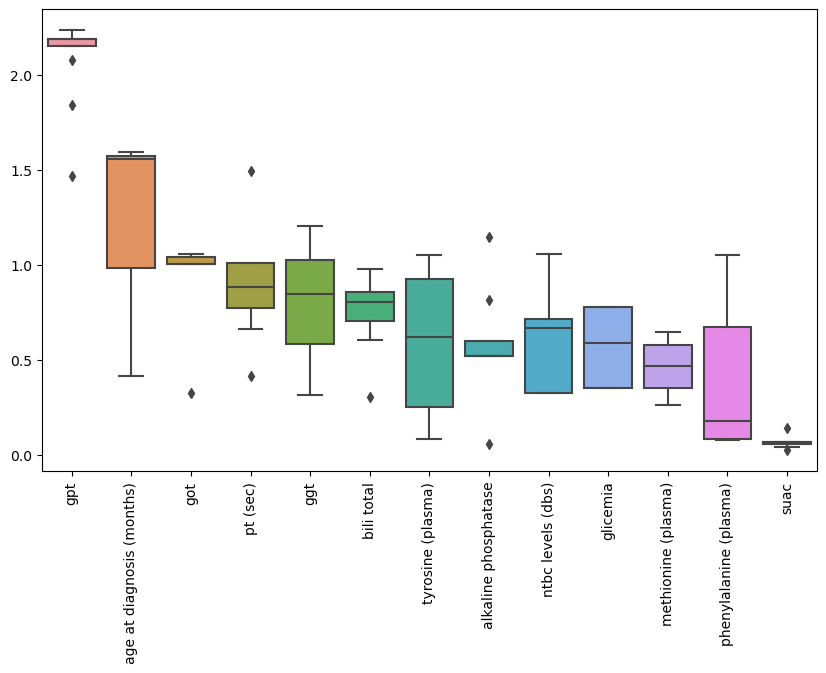

,gpt,age at diagnosis (months),got,pt (sec),ggt,bili total,tyrosine (plasma),alkaline phosphatase,ntbc levels (dbs),glicemia,methionine (plasma),phenylalanine (plasma)
age at diagnosis (months),ns,,,,,,,,,,,
got,ns,ns,,,,,,,,,,
pt (sec),ns,ns,ns,,,,,,,,,
ggt,ns,ns,ns,ns,,,,,,,,
bili total,ns,ns,ns,ns,ns,,,,,,,
tyrosine (plasma),*,ns,ns,ns,ns,ns,,,,,,
alkaline phosphatase,*,ns,ns,ns,ns,ns,ns,,,,,
ntbc levels (dbs),**,ns,ns,ns,ns,ns,ns,ns,,,,
glicemia,*,ns,ns,ns,ns,ns,ns,ns,ns,,,
methionine (plasma),*,ns,ns,ns,ns,ns,ns,ns,ns,ns,,


In [5]:
from utils import TwoObjectiveSolutions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp

names = []
impotances = []
studies   = rome
for study in studies:
    solutions = TwoObjectiveSolutions(study, auc_cutoff=0.7, s_cutoff=0).get_filtered_trials().filtered_trials

    names.append(study.study_name)
    impotances.append([solution.values for solution in solutions])
d_dict = dict(zip(names, impotances))
d_dict = {key.replace(" (Alpha-Fet)", ""): value for key, value in d_dict.items()}

data_dict = {key: [v[1] for v in value] for key, value in d_dict.items()}
# We'll transform this dictionary into a DataFrame
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# Calculate the mean of each column (ignoring NaN values), sort it in descending order
sorted_columns = df.mean().sort_values(ascending=False).index

# Reindex df columns with the sorted ones
df = df[sorted_columns]

# Initialize the figure and set the dimensions
plt.figure(figsize=(10, 6))

# Use seaborn to create boxplots
sns.boxplot(data=df)

# Optional: rotate x-axis labels if they overlap
plt.xticks(rotation=90)

# Show the plot
plt.show()

# Perform the Kruskal-Wallis test
_, p_value = kruskal(*[df[col].dropna() for col in df])

def format_pval(p):
    """Convert p-value into significance level"""
    if p < 0.001: return "***"
    elif p < 0.01: return "**"
    elif p < 0.05: return "*"
    else: return "ns"

# If p_value < 0.05, perform post-hoc Dunn's test
if p_value < 0.05:
    # Prepare the data for the Dunn's test: reshape and add a column with group IDs
    df_dunn = pd.melt(df.reset_index(), id_vars=['index'], value_vars=df.columns)
    df_dunn.columns = ['index', 'Treatment', 'value']
    
    # Perform the Dunn's test
    posthoc = sp.posthoc_dunn(df_dunn, val_col='value', group_col='Treatment')

    # Format the DataFrame
    posthoc = posthoc.applymap(format_pval)
    
    #display(posthoc)

import numpy as np
stats_df = posthoc.loc[sorted_columns,:][sorted_columns]

# Mask the upper triangular part of the DataFrame
mask = np.triu(np.ones(stats_df.shape)).astype(np.bool)
stats_df.where(~mask, '', inplace=True)

stats_df.iloc[1:,0:-1]

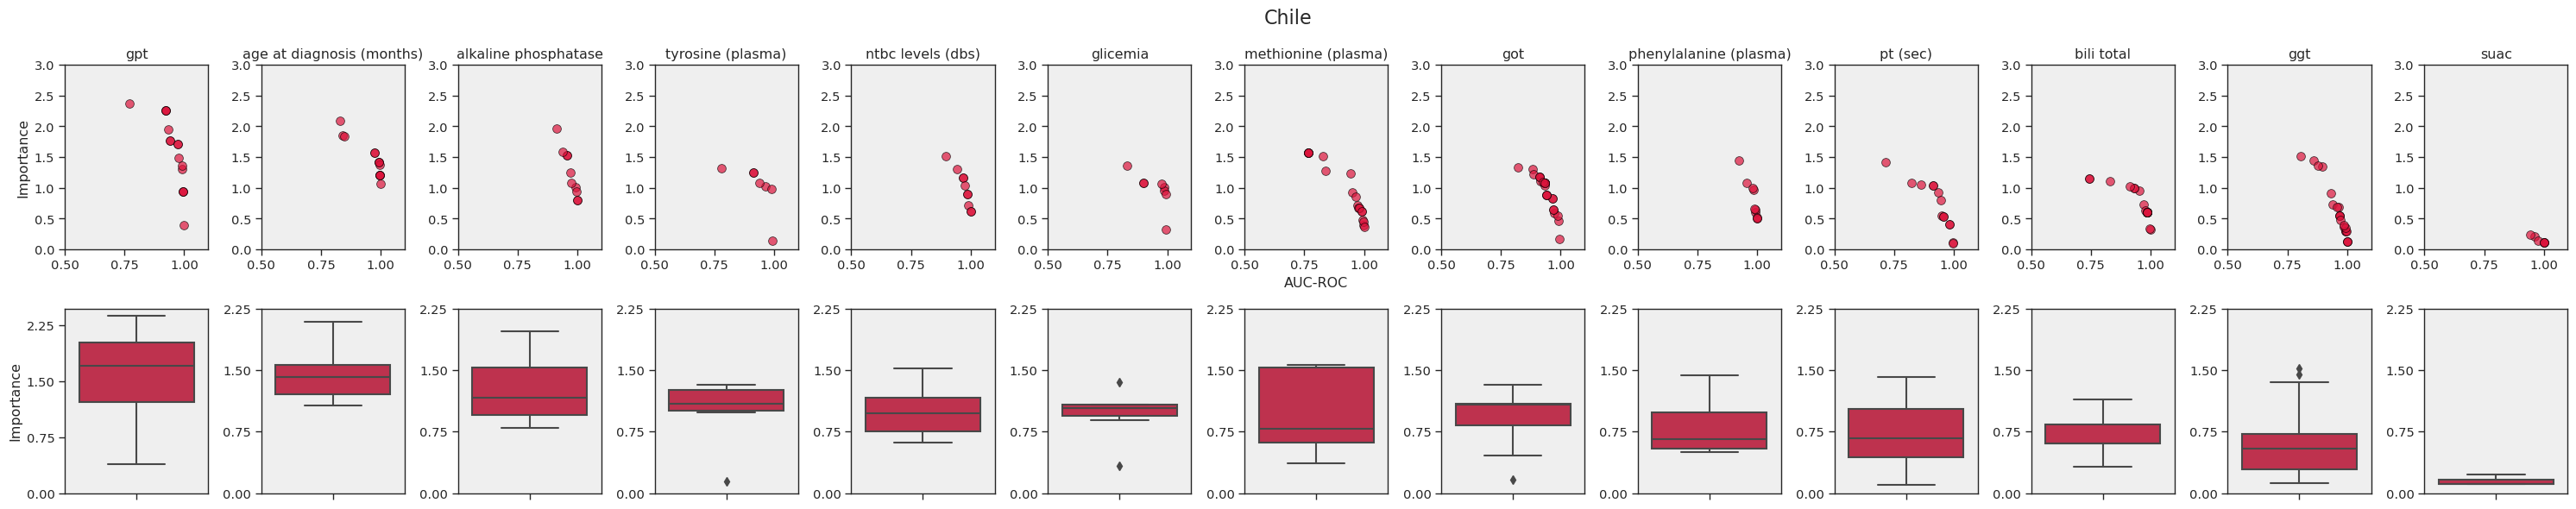

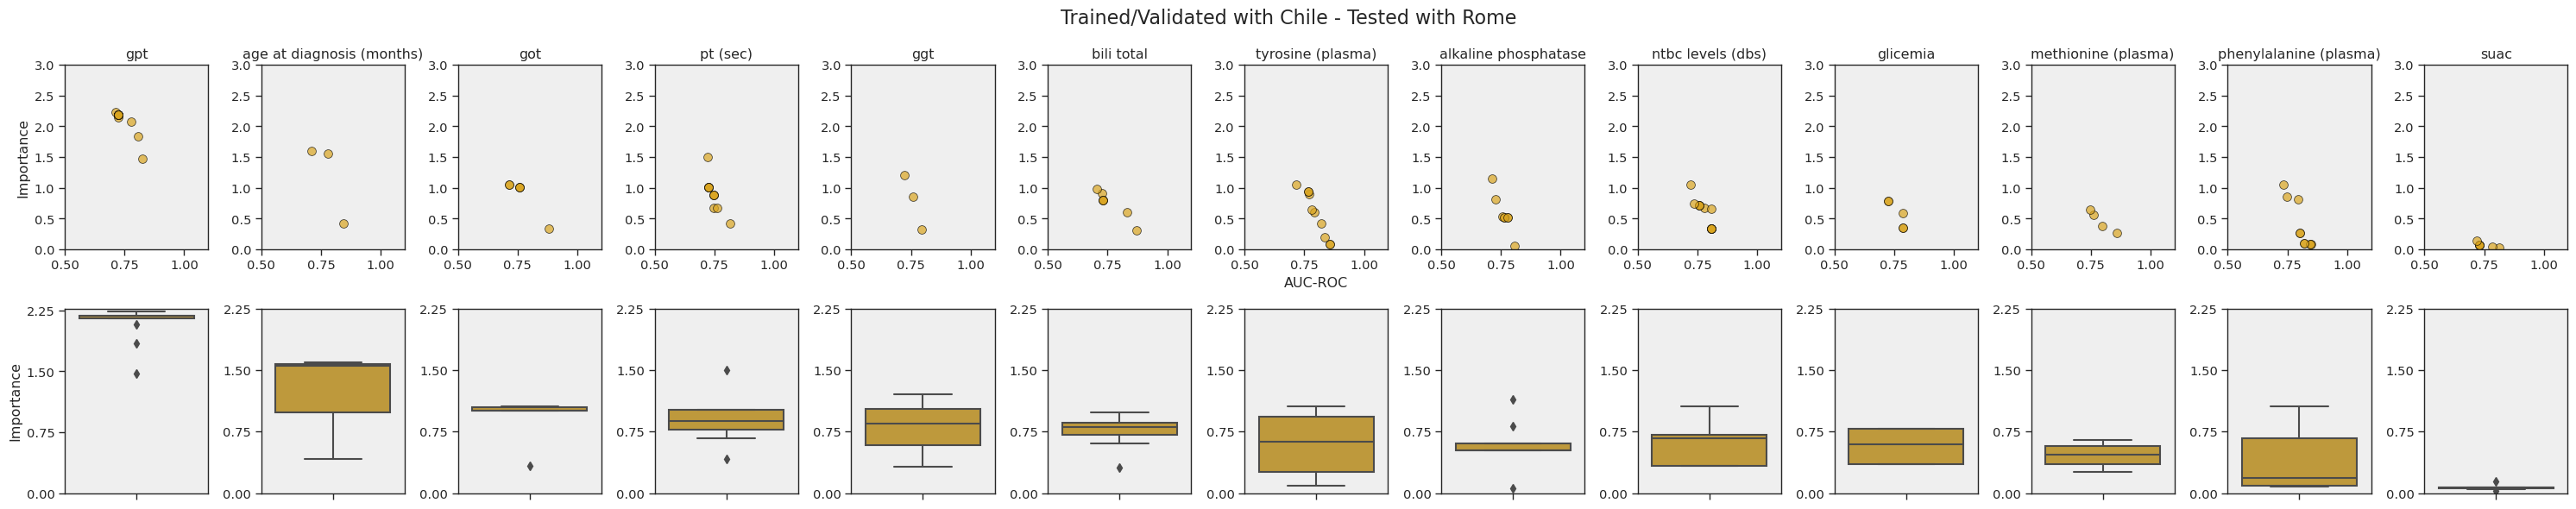

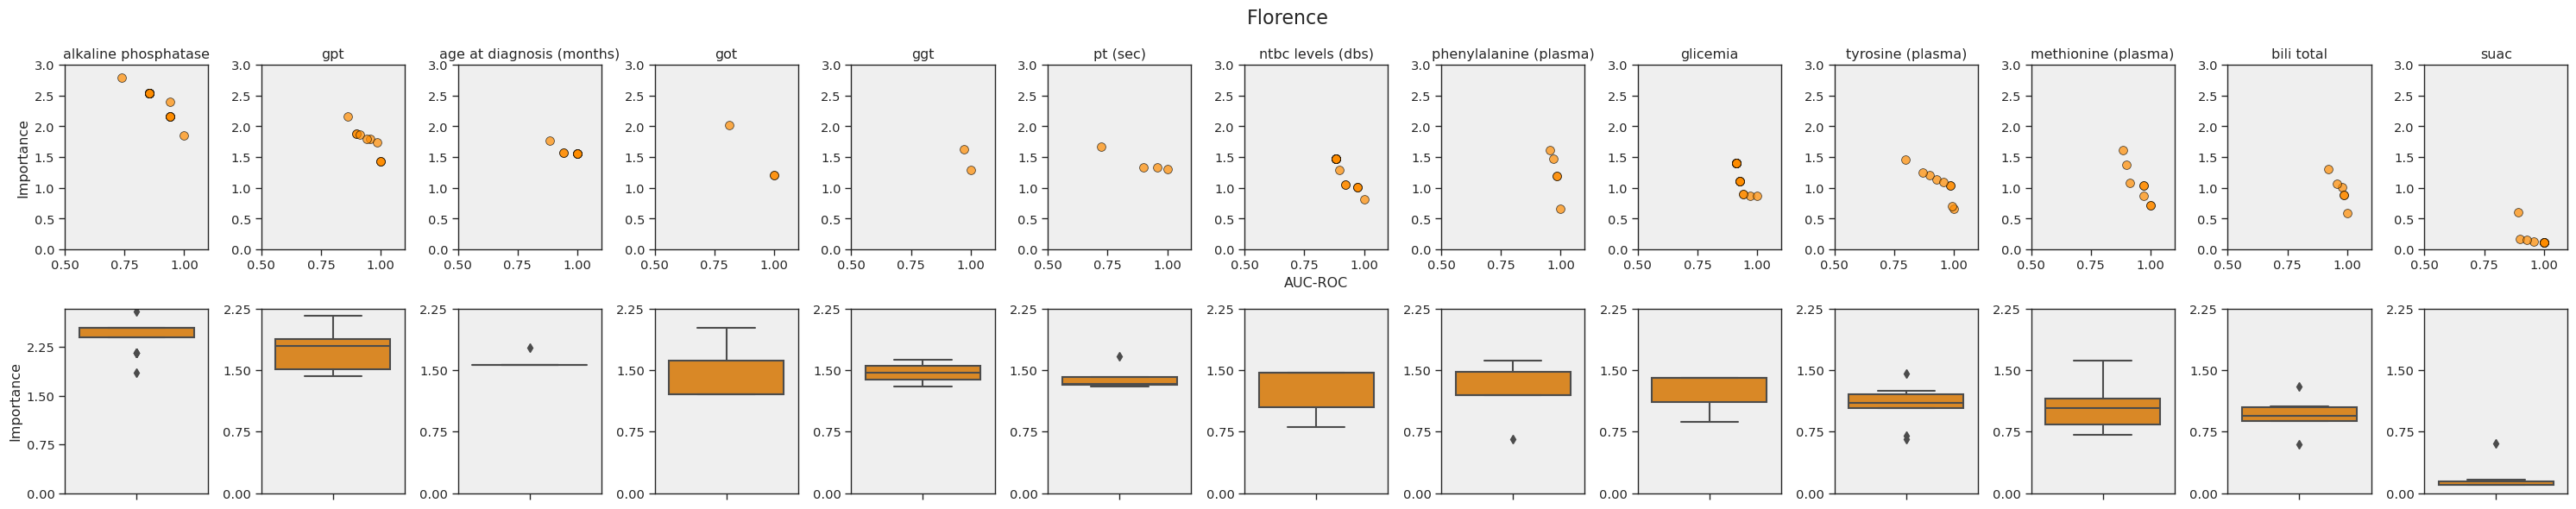

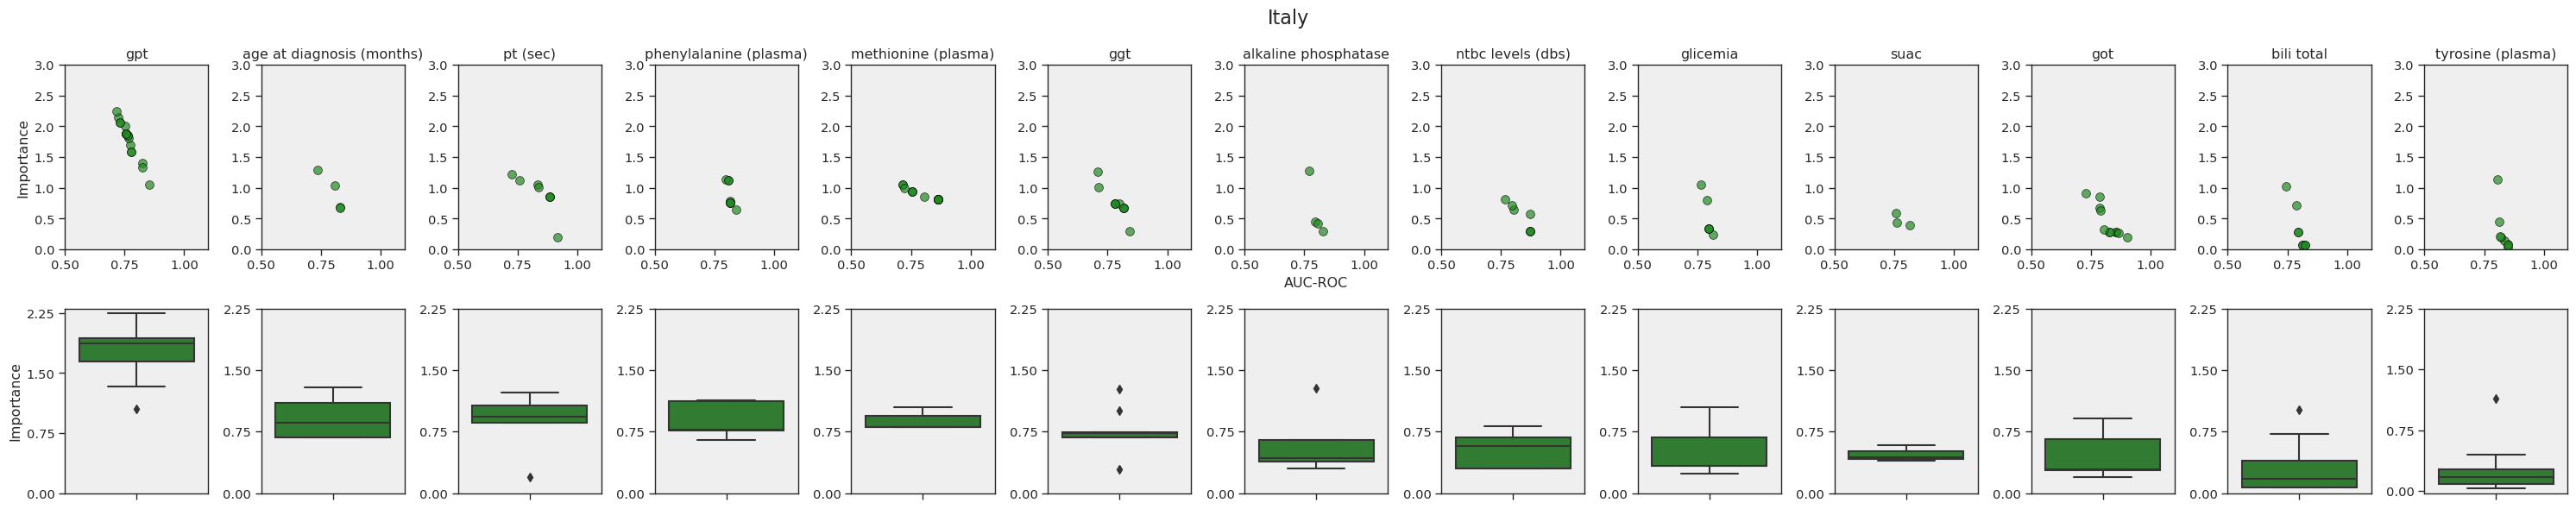

In [3]:
from utils import TwoObjectiveSolutions
import seaborn as sns

def plot_studies(studies, color, main_title):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    sns.set_theme(style="ticks", context="paper", font_scale=1.2)

    names = []
    impotances = []

    for study in studies:
        solutions = TwoObjectiveSolutions(study, auc_cutoff=0.7, s_cutoff=0).get_filtered_trials().filtered_trials

        names.append(study.study_name)
        impotances.append([solution.values for solution in solutions])
    data = dict(zip(names, impotances))

    # Remove substring "(Alpha-Fet)" from all the keys
    data = {key.replace(" (Alpha-Fet)", ""): value for key, value in data.items()}

    # Calculate the median of y-values for each key and sort the dictionary based on it
    medians = {key: np.mean([i[1] for i in value]) for key, value in data.items()}
    data = {k: v for k, v in sorted(data.items(), key=lambda item: medians[item[0]], reverse=True)}

    # Get top 5 items
    data = {k: data[k] for k in list(data.keys())[:13]}

    # Create subplots
    fig, axes = plt.subplots(2, 13, figsize=(30, 6))
    fig.suptitle(main_title, fontsize=16)

    # Create scatterplots and boxplots
    for idx, (ax_scatter, ax_boxplot, (key, value)) in enumerate(zip(axes[0], axes[1], data.items())):
        df = pd.DataFrame(value, columns=['x', 'y'])

        # Set background color for subplot
        ax_scatter.set_facecolor((0.8, 0.8, 0.8, 0.3))
        ax_boxplot.set_facecolor((0.8, 0.8, 0.8, 0.3))

        # Adjust marker transparency
        sns.scatterplot(x='x', y='y', data=df, ax=ax_scatter, color=color, edgecolor='black', s=50, alpha=0.7)

        ax_scatter.set_title(key)
        ax_scatter.set_xlim([0.5, 1.1])
        ax_scatter.set_ylim([0, 3])

        if idx == 0:
            ax_scatter.set_ylabel('Importance')  # Set y-label for the first scatter plot
        else:
            ax_scatter.set_ylabel('')  # Remove y-label for the other scatter plots

        # Set common x-label for the first row
        if idx == len(data) - 7:
            ax_scatter.set_xlabel('AUC-ROC')
        else:
            ax_scatter.set_xlabel('')  # Remove x-label for the other plots

        # Create boxplots and adjust transparency
        sns.boxplot(y='y', data=df, orient='h', ax=ax_boxplot, color=color, saturation=0.7, linewidth=1.5)
        ax_boxplot.set_yticks(np.arange(0, 3, 0.75))

        #ax_boxplot.set_xticks([])  # Remove x-ticks for vertical boxplots

        if idx == 0:
            ax_boxplot.set_ylabel('Importance')  # Set y-label for the first boxplot
        else:
            ax_boxplot.set_ylabel('')  # Remove y-label for the other boxplots

    plt.tight_layout()
    plt.show()


plot_studies(chile, "Crimson", "Chile")
plot_studies(rome, "Goldenrod", "Trained/Validated with Chile - Tested with Rome")
plot_studies(flor, "DarkOrange", "Florence")
plot_studies(italy, "ForestGreen", "Italy")

In [4]:
# import seaborn as sns

# def plot_studies(studies, color, main_title):
#     import numpy as np
#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     import pandas as pd

#     sns.set_theme(style="ticks", context="paper", font_scale=1.2)

#     names = []
#     impotances = []

#     for study in studies:
#         solutions = TwoObjectiveSolutions(study, auc_cutoff=0.7, s_cutoff=0).get_filtered_trials().filtered_trials

#         names.append(study.study_name)
#         impotances.append([solution.values for solution in solutions])
#     data = dict(zip(names, impotances))

#     # Remove substring "(Alpha-Fet)" from all the keys
#     data = {key.replace(" (Alpha-Fet)", ""): value for key, value in data.items()}

#     # Calculate the median of y-values for each key and sort the dictionary based on it
#     medians = {key: np.mean([i[1] for i in value]) for key, value in data.items()}
#     data = {k: v for k, v in sorted(data.items(), key=lambda item: medians[item[0]], reverse=True)}

#     # Get top 5 items
#     data = {k: data[k] for k in list(data.keys())[:7]}

#     # Create subplots
#     fig, axes = plt.subplots(2, 7, figsize=(15, 5))
#     fig.suptitle(main_title, fontsize=16)

#     # Create scatterplots and boxplots
#     for idx, (ax_scatter, ax_boxplot, (key, value)) in enumerate(zip(axes[0], axes[1], data.items())):
#         df = pd.DataFrame(value, columns=['x', 'y'])

#         sns.scatterplot(x='x', y='y', data=df, ax=ax_scatter, color=color, edgecolor='black', s=50)
#         ax_scatter.set_title(key)
#         ax_scatter.set_xlim([0.5, 1.1])
#         ax_scatter.set_ylim([0, 3])

#         if idx == 0:
#             ax_scatter.set_ylabel('Importance')  # Set y-label for the first scatter plot
#         else:
#             ax_scatter.set_ylabel('')  # Remove y-label for the other scatter plots

#         # Set common x-label for the first row
#         if idx == len(data) - 4:
#             ax_scatter.set_xlabel('AUC-ROC')
#         else:
#             ax_scatter.set_xlabel('')  # Remove x-label for the other plots

#         sns.boxplot(y='y', data=df, orient='h', ax=ax_boxplot, color=color)
#         ax_boxplot.set_yticks(np.arange(0, 3, 0.75))

#         if idx == 0:
#             ax_boxplot.set_ylabel('Importance')  # Set y-label for the first boxplot
#         else:
#             ax_boxplot.set_ylabel('')  # Remove y-label for the other boxplots

#     plt.tight_layout()
#     plt.show()





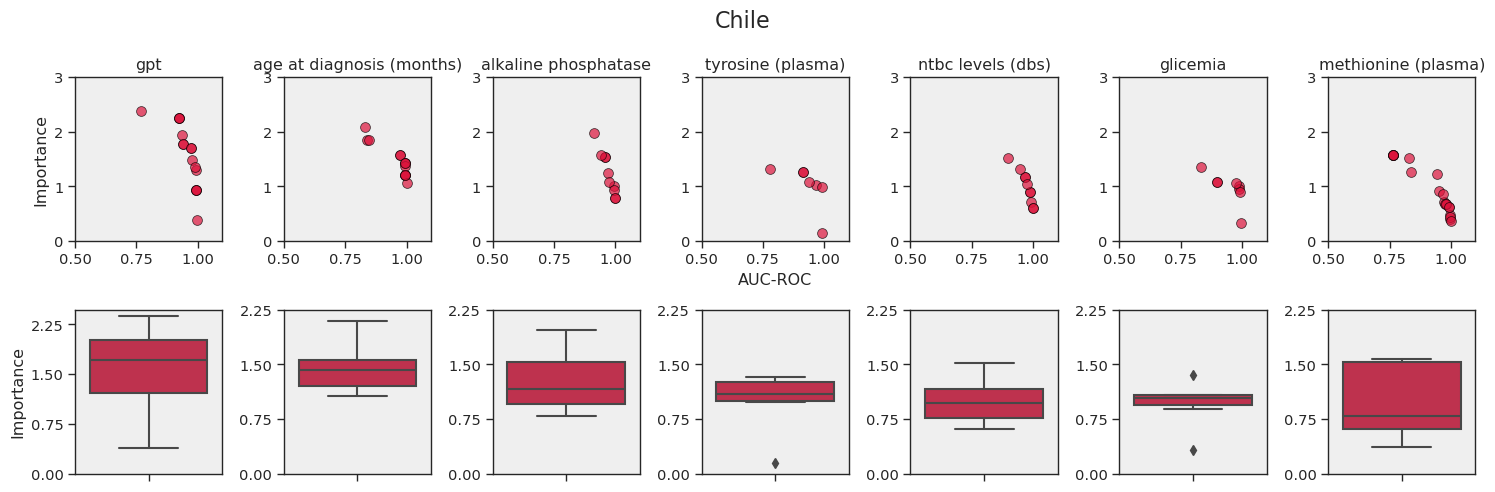

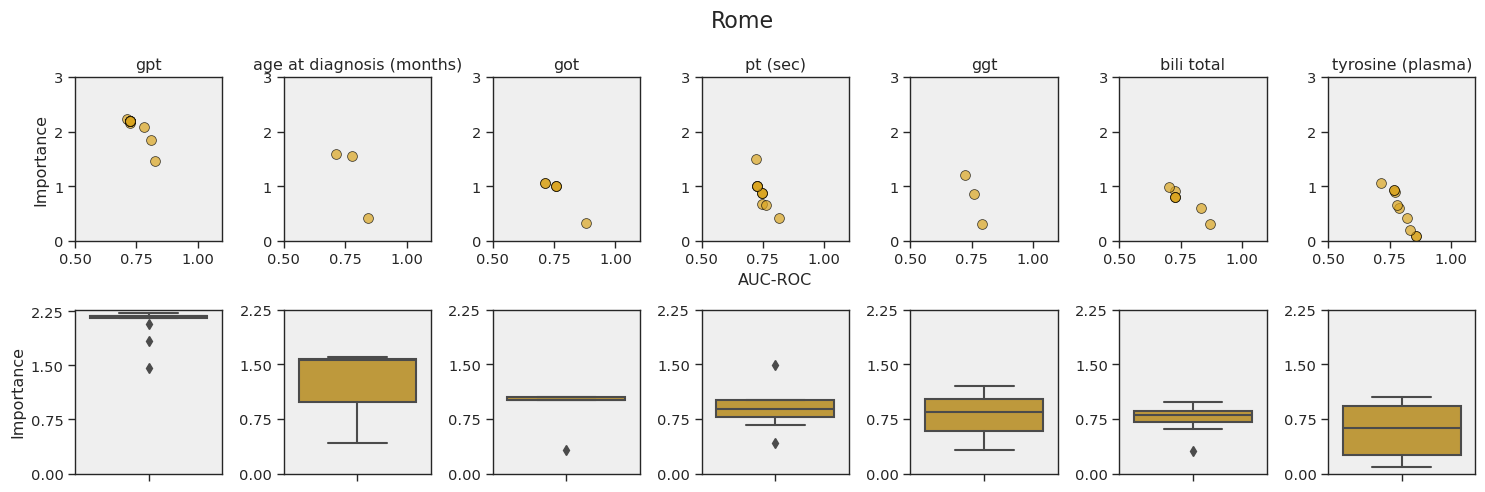

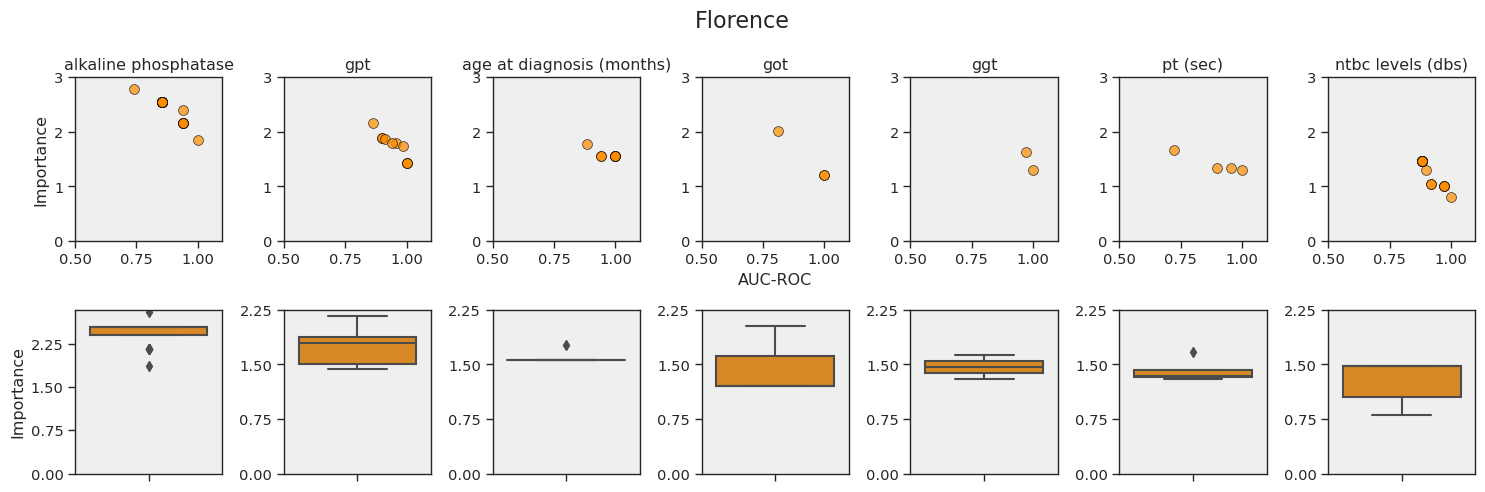

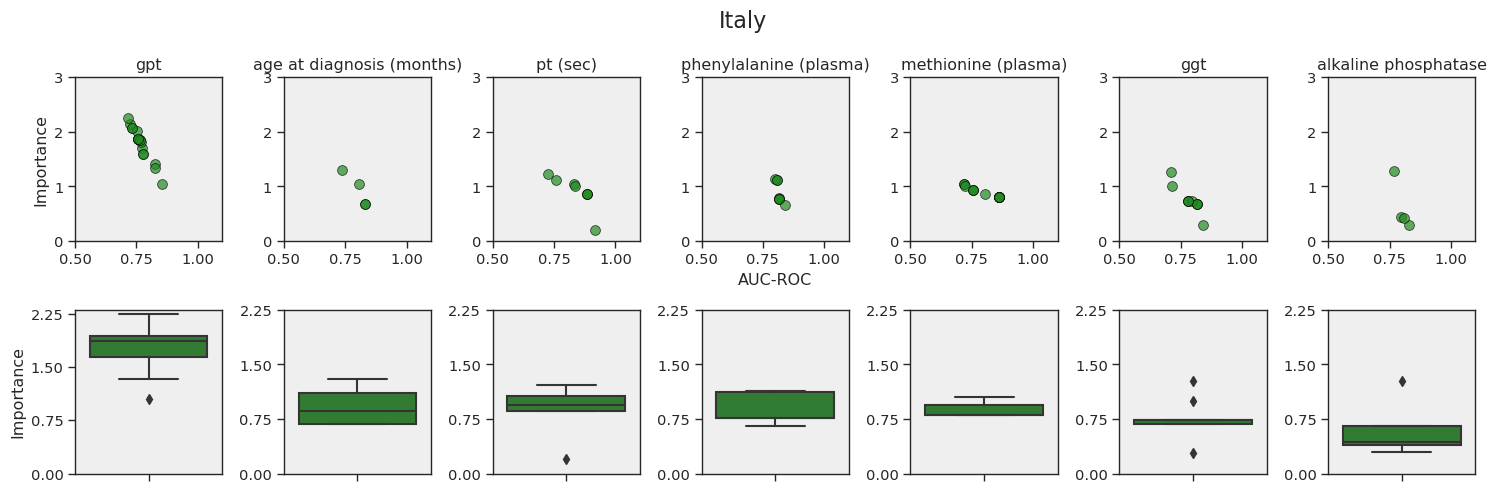

In [4]:
plot_studies(chile, "Crimson", "Chile")
plot_studies(rome, "Goldenrod", "Rome")
plot_studies(flor, "DarkOrange", "Florence")
plot_studies(italy, "ForestGreen", "Italy")

In [67]:
def plot_all_studies(studies, auc_cutoff, s_cutoff, main_title="", size=None):
    # Calculate average "S" for Pareto optimal trials with AUC > auc_cutoff in each study
    study_avg_S = []
    for study in studies:
        solutions = TwoObjectiveSolutions(study, auc_cutoff, s_cutoff)
        solutions.generate_dataframes()
        pareto_trials = solutions.df[(solutions.df['pareto'] == True) & (solutions.df['AUC'] > auc_cutoff)]
        avg_S = pareto_trials['S'].mean() if not pareto_trials.empty else 0
        study_avg_S.append((study, avg_S))
    
    # Sort studies based on average "S"
    study_avg_S.sort(key=lambda x: x[1], reverse=True)

    num_studies = len(studies)
    num_cols = num_studies if num_studies <= 3 else num_studies // 3 + (num_studies % 3 > 0)
    
    fig = make_subplots(rows=num_cols, cols=1, subplot_titles=[study[0].study_name.replace(" (Alpha-Fet)", "") for study in study_avg_S])
    #fig = make_subplots(rows=1, cols=num_studies, subplot_titles=[study[0].study_name for study in study_avg_S])

    
    max_y = -float('inf')
    min_x = float('inf')
    max_x = -float('inf')

    # Iterate over each study
    for i, (study, _) in enumerate(study_avg_S):
        solutions = TwoObjectiveSolutions(study, auc_cutoff, s_cutoff)
        solutions.generate_dataframes()

        # update the max_y, min_x and max_x for the y-axes and x-axes range 
        max_y = max(max_y, solutions.df["S"].max())
        min_x = min(min_x, solutions.df["AUC"].min())
        max_x = 1.01*max(max_x, solutions.df["AUC"].max())

        # Pareto optimal trials
        pareto_df = solutions.df[solutions.df['pareto'] == True]
        fig.add_trace(go.Scatter(x=pareto_df["AUC"], y=pareto_df["S"], mode='markers', marker_symbol='square', name='Pareto Optimal', legendgroup="group1", marker=dict(color='blue', opacity=0.9), showlegend=(i == 0)), row=(i%3)+1, col=(i//3)+1)
    #fig.add_trace(go.Scatter(x=pareto_df["AUC"], y=pareto_df["S"], mode='markers', marker_symbol='square', name='Pareto Optimal Trials', legendgroup="group1", marker=dict(color='blue', opacity=0.9), showlegend=(i == 0)), row=1, col=i+1)

        # Other trials
        other_trials_df = solutions.df[solutions.df['pareto'] == False]
        fig.add_trace(go.Scatter(x=other_trials_df["AUC"], y=other_trials_df["S"], mode='markers', name='Suboptimal', legendgroup="group2", marker=dict(color='red', opacity=0.2), showlegend=(i == 0)), row=(i%3)+1, col=(i//3)+1)

        # Add rectangle. Note that y1 = 1.1*max_y to ensure the rectangle reaches the end of y-axis in all subplots.
        fig.add_shape(type="rect",
              x0=solutions.auc_cutoff, y0=-0.02,  # y0 = minimum of y-axis range
              x1=1.0, y1=1.1*max_y,  # x1 = 1.0 (end of normalized x-axis), y1 = maximum of y-axis range
              line=dict(color="LightSeaGreen", width=2),
              fillcolor="LightSeaGreen", opacity=0.3,
              row=(i%3)+1, col=(i//3)+1)
        fig.add_shape(type="line",
                  x0=0.7, y0=-0.02,
                  x1=0.7, y1=1.1*max_y,
                  line=dict(color="Black", width=2, dash='dash'),
                  row=(i%3)+1, col=(i//3)+1)

        
        fig.update_yaxes(title_text='Importance', row=(i%3)+1, col=(i//3)+1)
        fig.update_xaxes(title_text='AUC-ROC', row=(i%3)+1, col=(i//3)+1)

    # Update layout to remove margins, show legend, and set main title
    fig.update_layout(
          autosize=False if size else True,
        width=size[0] if size else None,
        height=size[1] if size else None,
        margin=dict(l=0, r=0, t=50, b=0),  # increased top margin
        showlegend=True,
        title={
            'text': main_title,
            'y':.96,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'}
    )
    
    # Update annotations (subplot titles) to decrease font size
    fig.update_annotations(dict(
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=10),  # decrease font size to 10
    ))
    # fig.update_yaxes(title_text='Importance', row=(i%3)+1, col=(i//3)+1)
    # fig.update_xaxes(title_text='AUC-ROC', row=(i%3)+1, col=(i//3)+1)
    
    fig.add_annotation(
        x=0.76, y=0.1*max_y,  # this sets the position of the text
        text="0.7",  # this is the text to be displayed
        showarrow=False,  # this ensures that there's no arrow pointing from the text to the position
        xshift=-50,  # shifts the text 50 units to the left
        font=dict(
            size=16,  # sets the font size
            color="Black"  # sets the font color
        ),
        row=(i%3)+1, col=(i//3)+1)
    fig.show()
    return fig

import plotly.io as pio


fig =plot_all_studies([chile[1]], .7, 0, '1000 models per feature', size=(600, 300))
#plot_all_studies(rome, .75, 0, 'rome') 
#plot_all_studies(flor, .75, 0, 'flor') 
# plot_all_studies(italy, .75, 0, 'italy') 
dpi = 300
pio.write_image(fig, 'aa1.png', format='png', scale=dpi/96)


In [3]:

import warnings
warnings.filterwarnings("ignore")
from utils import *

# df_chile = pd.read_parquet("data/non_ntbc_df_chile.parquet.gzip")
# df_rome  = pd.read_parquet("data/non_ntbc_df_rome.parquet.gzip")
# df_flor  = pd.read_parquet("data/non_ntbc_df_flor.parquet.gzip")
# df_italy  = pd.read_parquet("data/non_ntbc_df_italy.parquet.gzip")

# df_chile = pd.read_parquet("data/df_chile.parquet.gzip")
# df_rome  = pd.read_parquet("data/df_rome.parquet.gzip")
# df_flor  = pd.read_parquet("data/df_flor.parquet.gzip")
# df_italy  = pd.read_parquet("data/df_italy.parquet.gzip")

# df_chile['Alpha-Fet'] = df_chile['Alpha-Fet'].astype('category')
# df_rome['Alpha-Fet'] = df_rome['Alpha-Fet'].astype('category')
# df_flor['Alpha-Fet'] = df_flor['Alpha-Fet'].astype('category')
# df_italy['Alpha-Fet'] = df_italy['Alpha-Fet'].astype('category')
# df_italy.reset_index(drop=True, inplace=True)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


studies = chile
# filtered_trials = [
#                         trial 
#                         for study in studies
#                         for trial in TwoObjectiveSolutions(study, auc_cutoff=0.75, s_cutoff=0).get_filtered_trials().filtered_trials
#                     ]
names = []
impotances = []

for study in studies:
    solutions = TwoObjectiveSolutions(study, auc_cutoff=0.75, s_cutoff=0).get_filtered_trials().filtered_trials


    names.append(study.study_name)
    impotances.append([solution.values[1] for solution in solutions])


data = dict(zip(names,impotances))

# Compute medians
medians = {key: np.median(values) for key, values in data.items()}

# Sort keys by median
sorted_keys = sorted(data.keys(), key=lambda x: medians[x], reverse=True)
data

{'age at diagnosis (months) (Alpha-Fet)': [1.1032794713974,
  0.7856990098953247,
  1.4072093963623047,
  0.1658797562122345,
  1.3290449380874634,
  0.9721758365631104,
  1.3355684280395508],
 'ntbc dosis mg/kg/day (Alpha-Fet)': [0.25978365540504456,
  0.1556643843650818,
  0.9191033244132996,
  0.22335729002952576,
  0.7632513046264648,
  0.5453640222549438,
  0.705284595489502],
 'ntbc levels (dbs) (Alpha-Fet)': [0.3128664493560791,
  0.41960418224334717,
  0.4817279279232025,
  1.6616922616958618,
  0.7126765251159668,
  0.2136746048927307],
 'suac (Alpha-Fet)': [0.0885641947388649,
  0.06666320562362671,
  0.07488659769296646,
  0.053479548543691635,
  0.09079398959875107],
 'methionine (plasma) (Alpha-Fet)': [1.2827388048171997,
  0.31746500730514526,
  1.2827388048171997,
  0.35662803053855896,
  0.7905473709106445,
  1.0842031240463257,
  0.1850937157869339,
  0.3945164680480957,
  1.0178638696670532],
 'tyrosine (plasma) (Alpha-Fet)': [0.9645026326179504,
  1.4944469928741455,

In [ ]:

# Transform the data
labels = []
values = []
for key in sorted_keys:
    labels.extend([key]*len(data[key]))
    values.extend(data[key])

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=labels, y=values)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Boxplot for Each Key')
plt.tight_layout()
plt.show()

In [7]:
from tqdm import tqdm
from pandas.errors import PerformanceWarning



def ranking_boxplots(
                    studies ,       
                    df_test ,      
                    df_train ,     
                    binary_target ,
                    Independent_testset ,
                    title,
                    ):
    filtered_trials = [
                        trial 
                        for study in studies
                        for trial in TwoObjectiveSolutions(study, auc_cutoff=0.75, s_cutoff=0).get_filtered_trials().filtered_trials
                    ]

    import warnings
    from pandas.errors import PerformanceWarning


    warnings.filterwarnings("ignore", category=PerformanceWarning)

    import copy
    AUCs = []
    df_ranks_abnormal = pd.DataFrame()
    df_ranks_healty = pd.DataFrame()

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=PerformanceWarning)
        for i, trial in tqdm(enumerate(copy.deepcopy(filtered_trials)), total=len(filtered_trials)):
            # print(trial.values)

            params_i = trial.params
            seed, kfold_splits, xgb_params = params_i.pop('seed'), params_i.pop('kfold_splits'), params_i

            model_instance = ModelInstance(
                df = df_train, 
                target = binary_target,
                xgb_params = xgb_params,
                kfold_splits = kfold_splits,
                Independent_testset = Independent_testset,
                Independent_testset_df = df_test,
                seed = seed,
                
            )
            AUCs.append(model_instance.get_AUC_on_test_data())
            feature_metrics      = model_instance.get_feature_explanation()
            df_ranks_abnormal[i] = feature_metrics["SHAP_abnormal"]
            df_ranks_healty[i]   = feature_metrics["SHAP_healty"]

    import plotly.express as px
    import numpy as np

    df_ranks_long = df_ranks_abnormal.T
    order = df_ranks_long.rank(axis="columns", ascending=False).median(axis="rows").sort_values().index
    #df_ranks_long["auc_score"] = AUCs
    df = df_ranks_long
    import plotly.graph_objects as go

    # Calculate the median of each variable and sort the columns in descending order
    median_values = df.median().sort_values(ascending=False)
    sorted_columns = median_values.index

    # Create a list to store the box traces
    box_traces = []

    # Iterate over each sorted column
    for column in sorted_columns:
        # Create a box trace for each variable
        box_trace = go.Box(
            y=df[column],
            name=column,
            marker_color='gray',  # Set the marker color to gray
            showlegend=False  # Hide the legend
        )
        # Add the box trace to the list
        box_traces.append(box_trace)

    # Create the layout
    layout = go.Layout(title=title,
        yaxis=dict(
            title='Importance'
        ),
        xaxis=dict(
            tickangle=45,  # Rotate the x-axis labels by 45 degrees
        ),
        autosize=False,  # Turn off autosizing
        width=800,  # Set the width of the figure
        height=300,  # Set the height of the figure
        margin=dict(
            l=0,  # Set left margin to 0
            r=0,  # Set right margin to 0
            t=30,  # Set top margin to 0
            b=0  # Set bottom margin to 0
        )
    )

    # Create the figure
    fig = go.Figure(data=box_traces, layout=layout)

    # Show the figure
    fig.show()

ranking_boxplots(studies = chile,df_test = df_chile, df_train = df_chile, binary_target = 'Alpha-Fet', Independent_testset= False, title = "Chile")
ranking_boxplots(studies = rome, df_test = df_rome, df_train = df_chile, binary_target = 'Alpha-Fet',Independent_testset= True, title = "Rome")
ranking_boxplots(studies = flor, df_test = df_flor, df_train = df_chile, binary_target = 'Alpha-Fet',Independent_testset= True, title = "Florence")
ranking_boxplots(studies = italy, df_test = df_italy, df_train = df_chile, binary_target = 'Alpha-Fet',Independent_testset= True, title = "Italy")



100%|██████████| 107/107 [00:50<00:00,  2.13it/s]


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


100%|██████████| 81/81 [00:52<00:00,  1.54it/s]


100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


In [13]:
import plotly.express as px
import numpy as np

# df_ranks_long = df_ranks_abnormal.T
# order = df_ranks_long.rank(axis="columns", ascending=False).median(axis="rows").sort_values().index
df_ranks_long["auc_score"] = AUCs

#fig_barplot = px.bar(df_ranks_abnormal, barmode="group")

def rank_sort(df_ranks_abnormal: pd.DataFrame) -> pd.Index:
    """This takes the dataframe, ranks its variables, and sorts them by the mean ranking"""
    return df_ranks_abnormal.rank(axis="rows").median(axis="columns").sort_values(ascending=False).index

order = rank_sort(df_ranks_abnormal) # Converts ranks to an ordered list

def wrapper_pcoorplot(df_ranks_abnormal, dims=order.tolist()):
    """Small wrapper around plotly parallel coordinates plot"""
    fig_ranks = px.parallel_coordinates(
        df_ranks_abnormal.T,
        dimensions=dims,
        color=df_ranks_long["auc_score"],
        # labels=labels_relabel,
        color_continuous_scale='BuGn',
    )

    # Calculate global min and max
    global_min = np.min(df_ranks_abnormal.values)
    global_max = np.max(df_ranks_abnormal.values)

    # Create a new 'range' key for each dimension in the figure
    for dimension in fig_ranks.data[0]['dimensions']:
        dimension['range'] = [global_min, global_max]

    fig_ranks.update_layout(
        yaxis_tickformat=".2f",
        coloraxis_colorbar=dict(title=f"{'AUC'} (test data)"),
    )

    return fig_ranks

# Creates the figure with the first [:15] features according to ranking
fig_abnormal = wrapper_pcoorplot(df_ranks_abnormal, order.tolist()[:10])
fig_abnormal.show()  # Show fig, as this is a notebook
